In [7]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import os

In [5]:
# Define paths and parameters
dataset_dir = 'E:\Year04\IRP\dataset\dogs'  # Replace with your dataset path
image_size = (224, 224)  # Resize images to this size
num_classes = 4  # Number of classes

In [8]:
# Load images and labels
images = []
labels = []

class_names = ['canine_scabies', 'fungal_infection', 'healthy', 'hypersensitivity_allergies']

for class_idx, class_name in enumerate(class_names):
    class_dir = os.path.join(dataset_dir, class_name)
    for image_name in os.listdir(class_dir):
        image_path = os.path.join(class_dir, image_name)
        image = load_img(image_path, target_size=image_size)  # Load and resize image
        image = img_to_array(image) / 255.0  # Normalize pixel values to [0, 1]
        images.append(image)
        labels.append(class_idx)

# Convert lists to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Convert labels to one-hot encoding
labels = to_categorical(labels, num_classes=num_classes)

In [9]:
from sklearn.model_selection import train_test_split

# Split the dataset
X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, random_state=42, stratify=labels)

print(f"Training data shape: {X_train.shape}")
print(f"Validation data shape: {X_val.shape}")

Training data shape: (2009, 224, 224, 3)
Validation data shape: (503, 224, 224, 3)


In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation for training data
train_datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# No augmentation for validation data
val_datagen = ImageDataGenerator()

# Apply augmentation to training data
train_generator = train_datagen.flow(X_train, y_train, batch_size=32)

# No augmentation for validation data
val_generator = val_datagen.flow(X_val, y_val, batch_size=32)

In [11]:
# Define the CNN model
def create_cnn_model(input_shape=(224, 224, 3), num_classes=4):
    model = models.Sequential([
        # Convolutional layers
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        # Fully connected layers
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),  # Dropout to prevent overfitting
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')  # Output layer
    ])
    return model

# Compile the model
model = create_cnn_model(input_shape, num_classes)

model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 111, 111, 32)     0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 26, 26, 128)     

In [12]:
# Train the model
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=50  # Adjust based on your needs
)

Epoch 1/50
63/63 [==============================] - 22s 298ms/step - loss: 1.3854 - accuracy: 0.2693 - val_loss: 1.3692 - val_accuracy: 0.3201
Epoch 2/50
63/63 [==============================] - 21s 334ms/step - loss: 1.3630 - accuracy: 0.2743 - val_loss: 1.3455 - val_accuracy: 0.2922
Epoch 3/50
63/63 [==============================] - 25s 390ms/step - loss: 1.3545 - accuracy: 0.2902 - val_loss: 1.3282 - val_accuracy: 0.2962
Epoch 4/50
63/63 [==============================] - 22s 350ms/step - loss: 1.3315 - accuracy: 0.3121 - val_loss: 1.3092 - val_accuracy: 0.3936
Epoch 5/50
63/63 [==============================] - 20s 315ms/step - loss: 1.3277 - accuracy: 0.3330 - val_loss: 1.2921 - val_accuracy: 0.3757
Epoch 6/50
63/63 [==============================] - 20s 316ms/step - loss: 1.2989 - accuracy: 0.3728 - val_loss: 1.3250 - val_accuracy: 0.3439
Epoch 7/50
63/63 [==============================] - 21s 329ms/step - loss: 1.2719 - accuracy: 0.3843 - val_loss: 1.2415 - val_accuracy: 0.4056

In [13]:
# Evaluate the model on the validation set
val_loss, val_accuracy = model.evaluate(val_generator)
print(f"Validation Accuracy: {val_accuracy:.4f}")

16/16 [==============================] - 1s 33ms/step - loss: 0.8371 - accuracy: 0.6640
Validation Accuracy: 0.6640


In [15]:
from sklearn.utils import class_weight

# Calculate class weights
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(np.argmax(y_train, axis=1)),
    y=np.argmax(y_train, axis=1)
)
class_weights = dict(enumerate(class_weights))

print("Class Weights:", class_weights)

# Train the model with class weights
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    validation_data=val_generator,
    validation_steps=len(val_generator),
    epochs=50,
    class_weight=class_weights
)

Class Weights: {0: 0.9423076923076923, 1: 0.9131818181818182, 2: 0.944078947368421, 3: 1.274746192893401}
Epoch 1/50
63/63 [==============================] - 17s 262ms/step - loss: 0.8024 - accuracy: 0.6570 - val_loss: 0.7788 - val_accuracy: 0.6859
Epoch 2/50
63/63 [==============================] - 19s 307ms/step - loss: 0.7894 - accuracy: 0.6779 - val_loss: 0.7893 - val_accuracy: 0.6978
Epoch 3/50
63/63 [==============================] - 18s 286ms/step - loss: 0.7447 - accuracy: 0.6775 - val_loss: 0.8787 - val_accuracy: 0.6779
Epoch 4/50
63/63 [==============================] - 19s 306ms/step - loss: 0.7392 - accuracy: 0.6745 - val_loss: 0.8241 - val_accuracy: 0.6859
Epoch 5/50
63/63 [==============================] - 20s 311ms/step - loss: 0.7498 - accuracy: 0.6974 - val_loss: 0.8362 - val_accuracy: 0.6700
Epoch 6/50
63/63 [==============================] - 19s 304ms/step - loss: 0.7328 - accuracy: 0.7053 - val_loss: 0.7379 - val_accuracy: 0.7217
Epoch 7/50
63/63 [==================

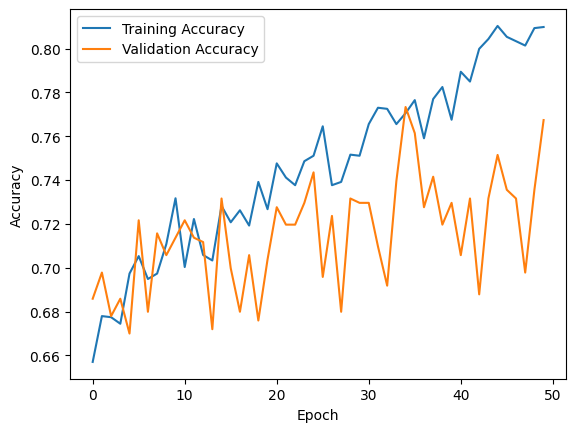

In [16]:
import matplotlib.pyplot as plt

# Plot training history
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()